In [1]:
import numpy as np
# from gym.utils import seeding
# from gym.spaces import Discrete, Tuple, Box
# import gym
from qiskit.quantum_info import state_fidelity
from qiskit import *
from numpy.linalg import matrix_power
import pandas as pd
# import cmath

In [2]:
def generate_target_circuit(n):
    s = np.array([1, 0])
    ht = GATES[0] @ GATES[1]
    return matrix_power(ht, n) @ s

def statevector_to_angles(state):
    svp = [abs(state[0])*np.exp(1j * np.angle(state[0])), abs(state[1])*np.exp(1j * np.angle(state[1]))]
    svp /= np.exp(1j * np.angle(state[0]))
    theta = 2 * np.arccos(abs(svp[0]))
    phi = np.angle(svp[1])
    if (phi < 0): phi += 2*np.pi
    return theta, phi
    # return np.cos(theta / 2) * np.array([1,0]) + np.exp(1j * phi) * np.sin(theta / 2) * np.array([0, 1])

def statevector_to_bloch_reg(state):
    theta, phi = statevector_to_angles(state)

    # take into consideration the poles
    for i in range(len(thetas)):
        if (theta in thetas[i]):
            theta_reg = i
    for i in range(len(phis)):
        if (phi in phis[i]):
            phi_reg = i

    if (theta_reg == 0):
        theta_reg = phi_reg = 0
    if (theta_reg == len(thetas)-1):
        theta_reg = len(thetas)-1
        phi_reg = len(phis)-1
    return (theta_reg, phi_reg)

def random_state_in_reg(reg):
    if (reg[0] == 0 or reg[0] == len(thetas)-1):
        phi = np.random.uniform(0, 2*np.pi)
    else:
        phi = np.random.uniform(phis[reg[1]].left, phis[reg[1]].right)
    theta = np.random.uniform(thetas[reg[0]].left, thetas[reg[0]].right)
    return np.cos(theta / 2) * np.array([1,0]) + np.exp(1j * phi) * np.sin(theta / 2) * np.array([0, 1])

# def statevector_to_bloch_point(state):
#     svp = [abs(state[0])*np.exp(1j * np.angle(state[0])), abs(state[1])*np.exp(1j * np.angle(state[1]))]
#     svp /= np.exp(1j * np.angle(svp[0]))
#     theta = 2 * np.arccos(abs(svp[0]))
#     phi = np.angle(svp[1])
#     return np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)

# def random_unitary(dim):
#   # follows the algorithm in https://arxiv.org/pdf/math-ph/0609050.pdf
#   Z = np.array([np.random.normal(0, 1) + np.random.normal(0, 1) * 1j for _ in range(dim ** 2)]).reshape(dim, dim)
#   Q, R = np.linalg.qr(Z)
#   diag = np.diagonal(R)
#   lamb = np.diag(diag) / np.absolute(diag)
#   unitary = np.matmul(Q, lamb)
#   assert np.allclose(unitary.conj().T @ unitary, np.eye(dim))
#   return unitary

In [3]:
n = 10**6
k = 16

GATES = {
    0: np.array([[1, 1], [1, -1]]) * 1/np.sqrt(2), # H
    1: np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]]), # T
    # 2: np.array([[0, 1], [1, 0]]), # X
    2: np.array([[1, 0], [0, 1]]) # I
}

goal = generate_target_circuit(n=n)
# goal = random_unitary(2)
thetas = np.array(pd.cut(np.linspace(0, np.pi, k), k, precision=10, include_lowest=True))
thetas[0] = pd.Interval(0, thetas[0].right, closed='both')
phis = np.array(pd.cut(np.linspace(0, 2*np.pi, 2*k), 2*k,  precision=10, include_lowest=True))
phis[0] = pd.Interval(0, phis[0].right, closed='both')
goal_reg = statevector_to_bloch_reg(goal)

states = [(i, j) for i in range(len(thetas)) for j in range(len(phis))]
values = np.zeros(len(thetas) * len(phis))

In [4]:
transitions = [np.zeros((len(states), len(states)), dtype=np.float16) for i in range(len(GATES))]

# building transition matrices
for s in states:
    for i in range(100):
        state = random_state_in_reg(s)
        for j in range(len(GATES)):
            n_state = statevector_to_bloch_reg(GATES[j] @ state)
            n_state_ind = states.index(n_state)
            state_ind = states.index(statevector_to_bloch_reg(state))
            transitions[j][state_ind][n_state_ind] += 1

for i in range(len(GATES)):
    for j in range(len(states)):
        transitions[i][j] = np.nan_to_num(transitions[i][j] / sum(transitions[i][j]))

/tmp/ipykernel_797000/2214690004.py:15: RuntimeWarning: invalid value encountered in divide
  transitions[i][j] = np.nan_to_num(transitions[i][j] / sum(transitions[i][j]))


In [5]:
def R(state, action):
    if (state == goal_reg):
        return 1
        # if (action <= len(GATES) - 2):
        #     return 0
        # else:
        #     return 0.1 # to encourage using identity
    else:
        return 0

In [6]:
def policy_eval(policy, discount_factor=0.8, epsilon=0.000001):
    V_old = np.zeros(len(states))
    while True:
    # for i in range(1):
        V_new = np.zeros(len(states))
        delta = 0
        for s in range(len(states)):
            v_fn = 0
            action_probs = policy[s]
            for a in range(len(GATES)):
                p_trans = transitions[a][s]
                p_next_states = np.nonzero(transitions[a][s])[0]
                for next_s in p_next_states:
                    v_fn += action_probs[a] * p_trans[next_s] * (R(states[s], a) + discount_factor * V_old[next_s])
            delta = max(delta, abs(v_fn - V_old[s]))
            V_new[s] = v_fn
        V_old = V_new
        if(delta < epsilon):
            break
    # since technically the entire north/south pole is one state, copy (0, 0) and (k-1, k-1) over
    # won't ever be used, but it is needed for the visualization
    for i in range(1, len(phis)):
        V_old[i] = V_old[0]
        V_old[len(thetas)*len(phis)-1-i] = V_old[len(thetas)*len(phis)-1]
    return np.array(V_old)

In [7]:
def policy_improvement(policy_eval_fn=policy_eval, discount_factor=0.8):
    def one_step_lookahead(s, V_old):
        actions = np.zeros(len(GATES))
        for a in range(len(GATES)):
            v_fn = 0
            p_trans = transitions[a][s]
            p_next_states = np.nonzero(transitions[a][s])[0]
            for next_s in p_next_states:
                v_fn += p_trans[next_s] * (R(states[s], a) + discount_factor * V_old[next_s])
            actions[a] = v_fn
        return actions
    policy = np.ones([len(states), len(GATES)]) / len(GATES)
    actions_values = np.zeros(len(GATES))

    while True:
        value_fn = policy_eval_fn(policy)
        policy_stable = True
        for s in range(len(states)):
            actions_values = one_step_lookahead(s, value_fn)
            best_action = np.argmax(actions_values)
            chosen_action = np.argmax(policy[s])
            if(best_action != chosen_action):
                policy_stable = False
            policy[s] = np.eye(len(GATES))[best_action]

        if(policy_stable):
            return policy, value_fn

In [8]:
n = 10**6
goal = generate_target_circuit(n=n)
goal_reg = statevector_to_bloch_reg(goal)

policy, v = policy_improvement(policy_eval)

In [9]:
np.count_nonzero(v)

512

In [10]:
optimal_programs = []
for i in range(k):
    converged = False
    while not converged:
        s = random_state_in_reg((0, 0))
        prog = []
        counter = 0
        while counter < 30:
            action = np.argmax(policy[states.index(statevector_to_bloch_reg(s))])
            next_s = GATES[action] @ s
            prog.append(action)
            # next_s = random_state_in_reg(statevector_to_bloch_reg(next_s))
            s = next_s
            counter += 1
            if (statevector_to_bloch_reg(s) == goal_reg):
                print('converged')
                converged = True
                break

    optimal_programs.append(prog)
optimal_programs

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


[[0, 1, 1, 0, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 0, 1, 1, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 0, 1, 1, 1, 1, 0],
 [0, 1, 1, 0, 1],
 [0, 1, 0, 1, 1, 1, 1, 0],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 1, 1, 1, 1, 1]]

In [11]:
prog = optimal_programs[np.argmin(np.array([len(i) for i in optimal_programs]))]
fidelities = []
print(prog)
# prog = [0, 1, 1, 0]
for i in range(1):
    s = np.array([1, 0])
    # s = random_state_in_reg((0,0))
    for a in prog:
        s = GATES[a] @ s
    f = state_fidelity(s, goal)
    if (statevector_to_bloch_reg(s) == goal_reg):
        break
        fidelities.append(f)
    # print(goal, s)
print(f)

[0, 1, 1, 0, 1]
0.9984173074634162


In [12]:
goals = []

# prog = optimal_programs[np.argmin(optimal_programs)]
# for i in range(k):
#     s = random_state_in_reg((0,0))
#     for a in prog:
#         s = GATES[a] @ s

# goals.append(s)
for i in range(200000):
    num = bin(i)[2:]
    psi = np.array([1,0])
    for j in num:
        psi = GATES[int(j)] @ psi
    # goals.append(generate_target_circuit(i))
    goals.append(psi)
    # goals.append(random_unitary(2) @ np.array([1,0]))
xp = []
yp = []
zp = []
for i in range(len(goals)):
    theta, phi = statevector_to_angles(goals[i])
    xp.append(np.sin(theta)*np.sin(phi))
    yp.append(np.sin(theta)*np.cos(phi))
    zp.append(np.cos(theta))

/tmp/ipykernel_797000/1925367473.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


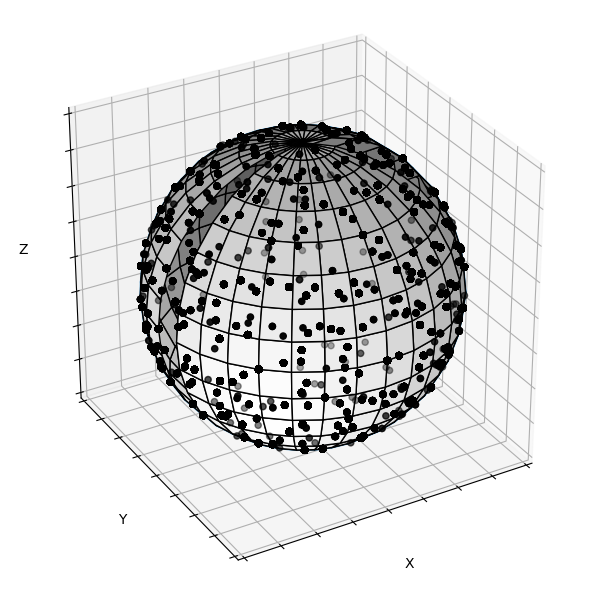

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# xp, yp, zp = np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)
# print(xp, yp, zp)
# draw a vector

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
fig = plt.figure(figsize=plt.figaspect(2)*1.5) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')
plt.tight_layout()
ax.set_box_aspect([1,1,1])

# Make data
r = 1.0

t = [0]
p = [-np.pi]
for i in range(len(thetas)):
    t.append(min(thetas[i].right, np.pi))
for i in range(len(phis)):
    p.append(min(phis[i].right, 2*np.pi))

# t = np.linspace(0, np.pi, k)
# p = np.linspace(-np.pi, np.pi, k)

theta,phi = np.meshgrid(p,t)

x = r*np.cos(theta)*np.sin(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(phi)

norm = plt.Normalize()
# colors = plt.cm.winter(norm(v.reshape(len(thetas), len(phis))))
surf = ax.plot_wireframe(x, y, z, alpha=0.8)
# surf = ax.plot_surface(x, y, z, facecolors=colors, alpha=1)

surf = ax.plot_surface(x, y, z, color='w', alpha=1)

surf.set_edgecolors('k')
ax.scatter(xp, yp, zp, color='k', s=20)
ax.view_init(azim=60, elev=30)
# ax.axis('off')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()

# ax.set_yticks([])
# ax.set_xticks([])
# ax.set_zticks([])

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])

plt.grid(True)
# plt.savefig('figures/policy.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()
